In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Define the base directory
base_dir = "E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset"

# List all files and directories in the base directory
print("Contents of the base directory:")
print(os.listdir(base_dir))

Contents of the base directory:
['COVID', 'COVID.metadata.xlsx', 'Lung_Opacity', 'Lung_Opacity.metadata.xlsx', 'Normal', 'Normal.metadata.xlsx', 'README.md.txt', 'Viral Pneumonia', 'Viral Pneumonia.metadata.xlsx']


In [3]:
# Find all metadata files in the base directory
metadata_files = glob.glob(os.path.join(base_dir, '*.metadata.xlsx'))

print("\nFound Metadata Files:")
for file in metadata_files:
    print(os.path.basename(file))


Found Metadata Files:
COVID.metadata.xlsx
Lung_Opacity.metadata.xlsx
Normal.metadata.xlsx
Viral Pneumonia.metadata.xlsx


In [4]:
# Define paths
root_dir = "E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset"
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Load metadata
metadata = {}
for cls in classes:
    metadata_path = os.path.join(root_dir, f'{cls}.metadata.xlsx' if cls != 'Viral Pneumonia' else 'Viral Pneumonia.metadata.xlsx')
    if os.path.exists(metadata_path):
        metadata_df = pd.read_excel(metadata_path)
        metadata[cls] = metadata_df
        print(f"Loaded metadata for class: {cls} with {len(metadata_df)} entries.")
    else:
        print(f"Metadata file for class {cls} not found at {metadata_path}.")

Loaded metadata for class: COVID with 3616 entries.
Loaded metadata for class: Lung_Opacity with 6012 entries.
Loaded metadata for class: Normal with 10192 entries.
Loaded metadata for class: Viral Pneumonia with 1345 entries.


In [5]:
# Inspect columns for each metadata DataFrame
for cls in classes:
    if cls in metadata:
        print(f"\nColumns in {cls} Metadata:")
        print(metadata[cls].columns)



Columns in COVID Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Lung_Opacity Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Normal Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Viral Pneumonia Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')


In [6]:
class COVID19RadiographyDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        """
        Args:
            image_label_pairs (list of tuples): List where each tuple contains (image_path, label).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_label_pairs = image_label_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
#         print(f"Loading image from: {image_path}")
        
        # Load image
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        
        # Print the size of the image to check channels
#         print(f"Image size: {image.size}, Image mode: {image.mode}")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [7]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Define image transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [8]:
# Define the root directory of the dataset
root_dir = "E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset"

# Define class names
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
# Map images to labels
label_mapping = {cls: idx for idx, cls in enumerate(classes)}
# Initialize a list to hold all mapped data
all_mapped_data = []

# Iterate through each class and map images to their labels
for cls in classes:
    images_dir = os.path.join(root_dir, cls, 'images')
    
    # List all image filenames
    image_filenames = os.listdir(images_dir)
    
    for img_filename in image_filenames:
        img_path = os.path.join(images_dir, img_filename)
        
        # Append the image path and label to the mapped data list
        all_mapped_data.append((img_path, label_mapping[cls]))

# Optionally, print the mapped data
print(f"Total Mapped Data: {len(all_mapped_data)}")
for img_path, label in all_mapped_data[:10]:  # Only print the first 10 items to avoid large output
    print(f"Image Path: {img_path}, Label: {label}")


# Convert to DataFrame for easier inspection
mapped_df = pd.DataFrame(all_mapped_data, columns=['image_path', 'label'])

# Display the first few entries
print("Mapped DataFrame:")
display(mapped_df.head())

# Check total number of mapped samples
print(f"Total images mapped: {len(mapped_df)}")

Total Mapped Data: 21165
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-10.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-100.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1000.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1001.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID-1002.png, Label: 0
Image Path: E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\COVID\images\COVID

,image_path,label
0,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
1,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
2,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
3,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0
4,E:/NSU/sem 9/MDY Research/Covid-19 dataset/cov...,0


Total images mapped: 21165


In [9]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.10
test_ratio = 0.20

# Calculate split sizes
total_size = len(mapped_df)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Testing samples: {test_size}")

Total samples: 21165
Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [10]:
# Shuffle the data
from sklearn.model_selection import train_test_split

# First split: Train and Temp (Val + Test)
train_data, temp_data = train_test_split(
    all_mapped_data,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=[x[1] for x in all_mapped_data]  # Stratify based on labels
)

# Second split: Validation and Test
val_size_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation size
val_data, test_data = train_test_split(
    temp_data,
    test_size=(1 - val_size_adjusted),
    random_state=42,
    stratify=[x[1] for x in temp_data]
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")

Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [11]:
from sklearn.utils.class_weight import compute_class_weight
# Extract labels from training data
# Compute class weights
train_labels = [sample[1] for sample in train_data]
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")


Class Weights: tensor([1.4634, 0.8802, 0.5192, 3.9318])


In [12]:
# Create Dataset instances
train_dataset = COVID19RadiographyDataset(train_data, transform=train_transform)
val_dataset = COVID19RadiographyDataset(val_data, transform=val_test_transform)
test_dataset = COVID19RadiographyDataset(test_data, transform=val_test_transform)

# Define batch size and number of workers
batch_size = 16
num_workers = 0 

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Number of batches - Train: 926, Val: 133, Test: 265


In [13]:
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")


Train data size: 14815
Validation data size: 2116
Test data size: 4234


In [14]:
print(train_data[0])  # Should print something like: (image_path, label)
print(val_data[0])
print(test_data[0])


('E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\\COVID\\images\\COVID-278.png', 0)
('E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\\Normal\\images\\Normal-4150.png', 2)
('E:/NSU/sem 9/MDY Research/Covid-19 dataset/covid 19 radiography/COVID-19_Radiography_Dataset\\COVID\\images\\COVID-868.png', 0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2282355].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8905448].


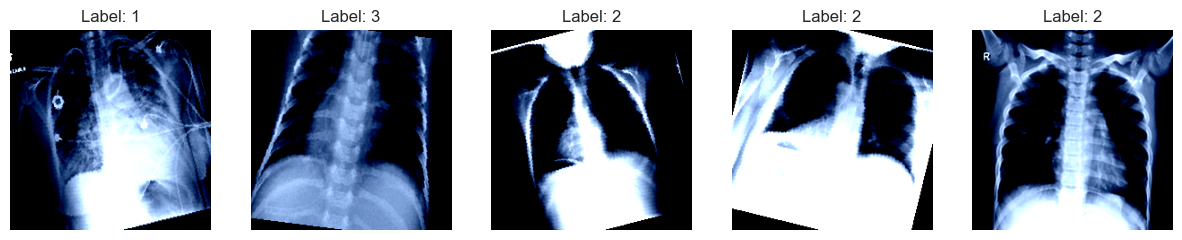

In [15]:
import matplotlib.pyplot as plt

# Check first batch
for batch_idx, (images, labels) in enumerate(train_loader):
    if batch_idx == 0:
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            ax = axes[i]
            ax.imshow(images[i].permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
            ax.set_title(f"Label: {labels[i].item()}")
            ax.axis('off')
        plt.show()
        break  # Exit after the first batch


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10136\514221396.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=train_label_counts.values, palette='viridis', legend = 'False')


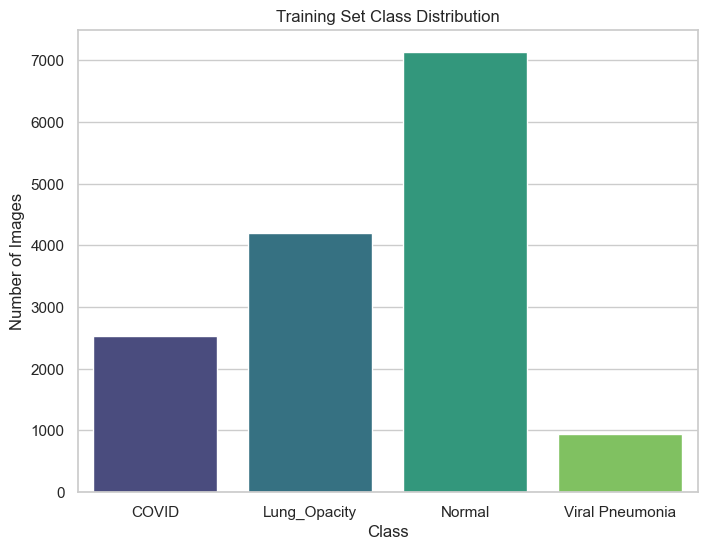

In [16]:
# Count class distribution in training set
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=train_label_counts.values, palette='viridis', legend = 'False')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [17]:
# import matplotlib.pyplot as plt

# def display_images_from_loader(loader, num_images=5):
#     data_iter = iter(loader)
#     images, labels = next(data_iter)

#     # Ensure num_images does not exceed batch size
#     num_images = min(num_images, images.size(0))  # Adjust if batch size is smaller

#     # Create a figure with subplots
#     fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

#     for i in range(num_images):
#         ax = axes[i]
#         image = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
#         ax.imshow(image)
#         ax.set_title(f"Label: {labels[i].item()}")
#         ax.axis('off')
#         print(f"Image {i+1} shape: {images[i].shape}")  # Print image shape to verify resize

#     plt.show()

# # Check train_loader
# print("Training images:")
# display_images_from_loader(train_loader)

# # Check val_loader
# print("Validation images:")
# display_images_from_loader(val_loader)

# # Check test_loader
# print("Testing images:")
# display_images_from_loader(test_loader)


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [19]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2, self).__init__()
        
        # Load MobileNetV2 without ImageNet weights (pretrained=False)
        self.model = models.mobilenet_v2(pretrained=False)
        
        # Replace the classifier with the number of classes you need
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)
    
    def forward(self, x):
        return self.model(x)

## FCA block

In [21]:
import torch.nn as nn
import torch.fft 

class FrequencyChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(FrequencyChannelAttention, self).__init__()
        self.channels = channels
        self.reduction = reduction
        
        # Squeeze operation in frequency domain
        self.squeeze = nn.Conv2d(channels, channels // reduction, kernel_size=1)
        self.excitation = nn.Conv2d(channels // reduction, channels, kernel_size=1)
        
    def forward(self, x):
        # Apply DCT along spatial dimensions to get frequency representation
        freq = torch.fft.fft2(x, norm="ortho")
        
        # Take the magnitude of the frequency representation
        freq_magnitude = torch.abs(freq)
        
        # Squeeze and Excitation in frequency domain
        squeezed = self.squeeze(freq_magnitude)
        activated = torch.relu(squeezed)
        excited = self.excitation(activated)
        
        # Apply a sigmoid to get channel-wise attention weights
        attention = torch.sigmoid(excited)
        
        # Apply attention weights to original input
        x = x * attention
        
        return x

## model with attention block 

In [23]:
import torch.nn as nn
import torchvision.models as models

class MobileNetV2WithFCA(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2WithFCA, self).__init__()
        
        # Load MobileNetV2 without pre-trained weights
        self.mobilenet = models.mobilenet_v2(weights=None)
        
        # Get the number of output channels from the last convolutional layer
        bottleneck_channels = self.mobilenet.last_channel
        
        # Define an FCA block to match the bottleneck output channels
        self.fca = FrequencyChannelAttention(channels=bottleneck_channels)
        
        # Replace the classifier with a new one for the specified number of classes
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(bottleneck_channels, num_classes)
        )
    
    def forward(self, x):
        # Forward pass through MobileNetV2 feature extractor
        x = self.mobilenet.features(x)
        
        # Apply FCA block after bottleneck
        x = self.fca(x)
        
        # Global average pooling
        x = x.mean([2, 3])  # Equivalent to nn.AdaptiveAvgPool2d((1, 1)) and flatten
        
        # Forward pass through the classifier
        x = self.mobilenet.classifier(x)
        
        return x


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model for binary or multi-class classification
num_classes = 4  # Modify based on your dataset (e.g., 2 for binary classification, 4 for multi-class)
model = MobileNetV2WithFCA(num_classes=num_classes)  # For RGB images

# Move the model to the GPU (or CPU if GPU is not available)
model.to(device)

# Check model architecture
print(model)

MobileNetV2WithFCA(
  (mobilenet): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kerne

In [25]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device='cuda'):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = None
    
    print(f"Using device: {device}")
    
    # Move model to the correct device
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 30)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
                # Move data to the correct device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Scheduler step
            if phase == 'train':
                scheduler.step()
            
            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            
            # Check if this is the best model so far in validation phase
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
        
        print(f"End of Epoch {epoch + 1}: Train Loss - {history['train_loss'][-1]:.4f}, "
              f"Val Loss - {history['val_loss'][-1]:.4f}")
    
    print(f'\nTraining complete. Best Validation Accuracy: {best_acc:.4f}')
    
    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    return model, history

# Define number of epochs
num_epochs = 25

# Ensure you have set the device correctly (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming model, criterion, optimizer, scheduler, train_loader, and val_loader are defined properly

trained_model, history = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device=device
)


Using device: cuda
Using device: cuda

Epoch 1/25
------------------------------


Train Phase: 100%|██████████| 926/926 [04:43<00:00,  3.27it/s]


Train Loss: 1.0576, Accuracy: 0.5158


Val Phase: 100%|██████████| 133/133 [00:27<00:00,  4.91it/s]


Val Loss: 0.7608, Accuracy: 0.6252
End of Epoch 1: Train Loss - 1.0576, Val Loss - 0.7608

Epoch 2/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:25<00:00,  6.36it/s]


Train Loss: 0.8132, Accuracy: 0.6078


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.31it/s]


Val Loss: 0.7183, Accuracy: 0.6371
End of Epoch 2: Train Loss - 0.8132, Val Loss - 0.7183

Epoch 3/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:24<00:00,  6.40it/s]


Train Loss: 0.7227, Accuracy: 0.6559


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.03it/s]


Val Loss: 0.6067, Accuracy: 0.7382
End of Epoch 3: Train Loss - 0.7227, Val Loss - 0.6067

Epoch 4/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:25<00:00,  6.38it/s]


Train Loss: 0.6677, Accuracy: 0.6919


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.20it/s]


Val Loss: 0.5653, Accuracy: 0.7387
End of Epoch 4: Train Loss - 0.6677, Val Loss - 0.5653

Epoch 5/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:25<00:00,  6.37it/s]


Train Loss: 0.6062, Accuracy: 0.7211


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.07it/s]


Val Loss: 0.5008, Accuracy: 0.7878
End of Epoch 5: Train Loss - 0.6062, Val Loss - 0.5008

Epoch 6/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:23<00:00,  6.44it/s]


Train Loss: 0.5736, Accuracy: 0.7395


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.36it/s]


Val Loss: 0.4391, Accuracy: 0.7883
End of Epoch 6: Train Loss - 0.5736, Val Loss - 0.4391

Epoch 7/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:25<00:00,  6.36it/s]


Train Loss: 0.5245, Accuracy: 0.7595


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.00it/s]


Val Loss: 0.4302, Accuracy: 0.8152
End of Epoch 7: Train Loss - 0.5245, Val Loss - 0.4302

Epoch 8/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:26<00:00,  6.33it/s]


Train Loss: 0.4982, Accuracy: 0.7766


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.13it/s]


Val Loss: 0.4089, Accuracy: 0.8455
End of Epoch 8: Train Loss - 0.4982, Val Loss - 0.4089

Epoch 9/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:26<00:00,  6.34it/s]


Train Loss: 0.4778, Accuracy: 0.7839


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 13.93it/s]


Val Loss: 0.4021, Accuracy: 0.8332
End of Epoch 9: Train Loss - 0.4778, Val Loss - 0.4021

Epoch 10/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:27<00:00,  6.27it/s]


Train Loss: 0.4588, Accuracy: 0.7963


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 13.92it/s]


Val Loss: 0.3445, Accuracy: 0.8469
End of Epoch 10: Train Loss - 0.4588, Val Loss - 0.3445

Epoch 11/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:26<00:00,  6.33it/s]


Train Loss: 0.3941, Accuracy: 0.8207


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.03it/s]


Val Loss: 0.3127, Accuracy: 0.8672
End of Epoch 11: Train Loss - 0.3941, Val Loss - 0.3127

Epoch 12/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:26<00:00,  6.33it/s]


Train Loss: 0.3847, Accuracy: 0.8256


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 13.95it/s]


Val Loss: 0.2983, Accuracy: 0.8733
End of Epoch 12: Train Loss - 0.3847, Val Loss - 0.2983

Epoch 13/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:26<00:00,  6.32it/s]


Train Loss: 0.3782, Accuracy: 0.8283


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.16it/s]


Val Loss: 0.2957, Accuracy: 0.8648
End of Epoch 13: Train Loss - 0.3782, Val Loss - 0.2957

Epoch 14/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:24<00:00,  6.43it/s]


Train Loss: 0.3740, Accuracy: 0.8300


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.10it/s]


Val Loss: 0.2880, Accuracy: 0.8814
End of Epoch 14: Train Loss - 0.3740, Val Loss - 0.2880

Epoch 15/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:24<00:00,  6.40it/s]


Train Loss: 0.3659, Accuracy: 0.8385


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.26it/s]


Val Loss: 0.2873, Accuracy: 0.8814
End of Epoch 15: Train Loss - 0.3659, Val Loss - 0.2873

Epoch 16/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:24<00:00,  6.41it/s]


Train Loss: 0.3575, Accuracy: 0.8384


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.11it/s]


Val Loss: 0.2891, Accuracy: 0.8691
End of Epoch 16: Train Loss - 0.3575, Val Loss - 0.2891

Epoch 17/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:34<00:00,  5.99it/s]


Train Loss: 0.3603, Accuracy: 0.8381


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 13.86it/s]


Val Loss: 0.2876, Accuracy: 0.8828
End of Epoch 17: Train Loss - 0.3603, Val Loss - 0.2876

Epoch 18/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:35<00:00,  5.95it/s]


Train Loss: 0.3548, Accuracy: 0.8400


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 13.60it/s]


Val Loss: 0.2808, Accuracy: 0.8752
End of Epoch 18: Train Loss - 0.3548, Val Loss - 0.2808

Epoch 19/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:36<00:00,  5.90it/s]


Train Loss: 0.3530, Accuracy: 0.8398


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 13.52it/s]


Val Loss: 0.2789, Accuracy: 0.8738
End of Epoch 19: Train Loss - 0.3530, Val Loss - 0.2789

Epoch 20/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:29<00:00,  6.18it/s]


Train Loss: 0.3476, Accuracy: 0.8410


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 14.07it/s]


Val Loss: 0.2893, Accuracy: 0.8800
End of Epoch 20: Train Loss - 0.3476, Val Loss - 0.2893

Epoch 21/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:31<00:00,  6.10it/s]


Train Loss: 0.3374, Accuracy: 0.8479


Val Phase: 100%|██████████| 133/133 [00:10<00:00, 13.14it/s]


Val Loss: 0.2768, Accuracy: 0.8828
End of Epoch 21: Train Loss - 0.3374, Val Loss - 0.2768

Epoch 22/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:36<00:00,  5.90it/s]


Train Loss: 0.3391, Accuracy: 0.8495


Val Phase: 100%|██████████| 133/133 [00:09<00:00, 13.61it/s]


Val Loss: 0.2735, Accuracy: 0.8837
End of Epoch 22: Train Loss - 0.3391, Val Loss - 0.2735

Epoch 23/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:35<00:00,  5.95it/s]


Train Loss: 0.3325, Accuracy: 0.8491


Val Phase: 100%|██████████| 133/133 [00:10<00:00, 13.04it/s]


Val Loss: 0.2765, Accuracy: 0.8828
End of Epoch 23: Train Loss - 0.3325, Val Loss - 0.2765

Epoch 24/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:25<00:00,  6.37it/s]


Train Loss: 0.3456, Accuracy: 0.8461


Val Phase: 100%|██████████| 133/133 [00:11<00:00, 11.65it/s]


Val Loss: 0.2735, Accuracy: 0.8823
End of Epoch 24: Train Loss - 0.3456, Val Loss - 0.2735

Epoch 25/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:28<00:00,  6.25it/s]


Train Loss: 0.3391, Accuracy: 0.8475


Val Phase: 100%|██████████| 133/133 [00:11<00:00, 12.01it/s]

Val Loss: 0.2710, Accuracy: 0.8833
End of Epoch 25: Train Loss - 0.3391, Val Loss - 0.2710

Training complete. Best Validation Accuracy: 0.8837


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Testing: 100%|██████████| 265/265 [01:01<00:00,  4.32it/s]


Classification Report:
                 precision    recall  f1-score   support

          COVID       0.84      0.92      0.87       723
   Lung_Opacity       0.90      0.81      0.85      1203
         Normal       0.89      0.91      0.90      2039
Viral Pneumonia       0.90      0.96      0.92       269

       accuracy                           0.88      4234
      macro avg       0.88      0.90      0.89      4234
   weighted avg       0.88      0.88      0.88      4234



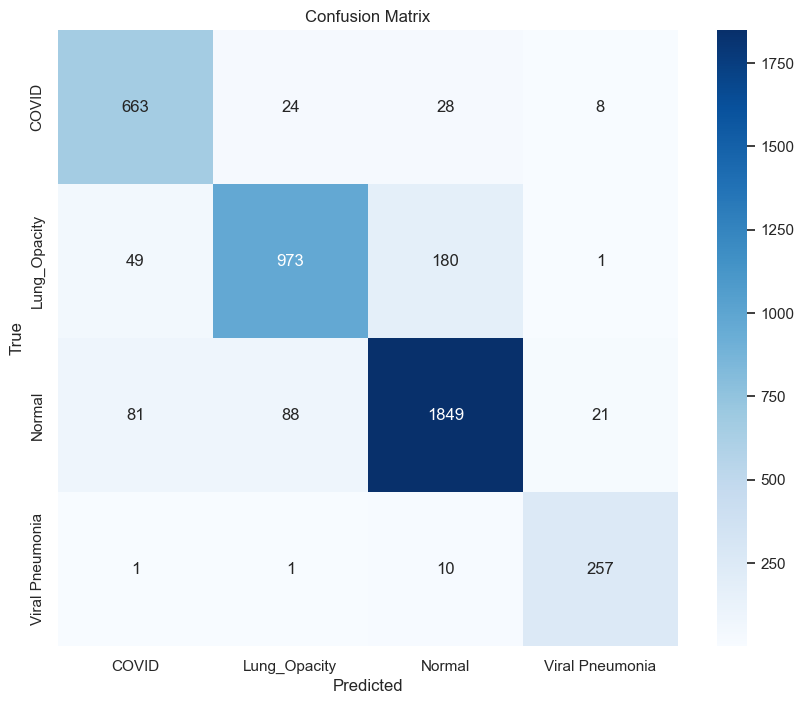

In [28]:
# Evaluate the model on the test set
evaluate_model(trained_model, test_loader, classes)

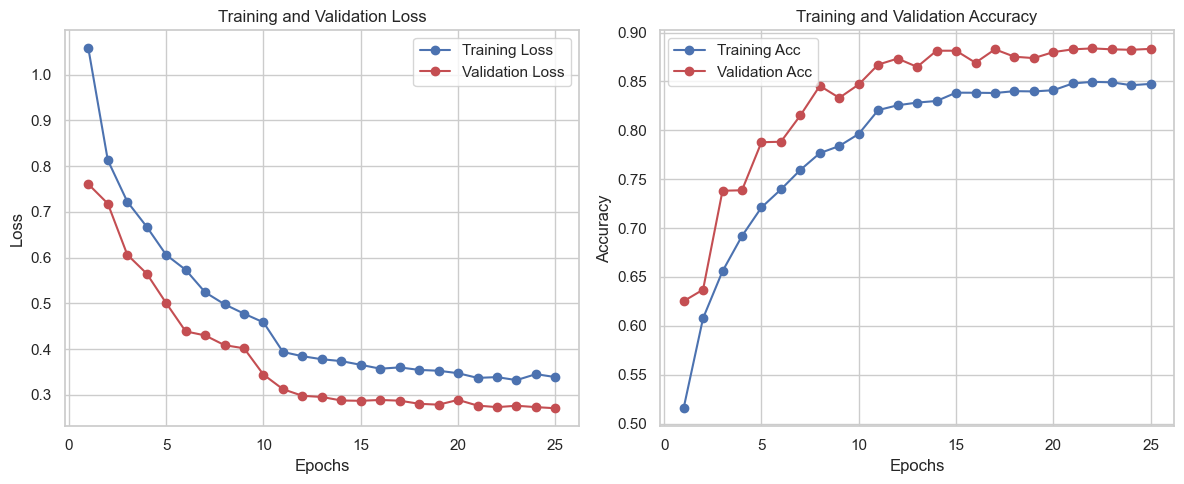

In [29]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

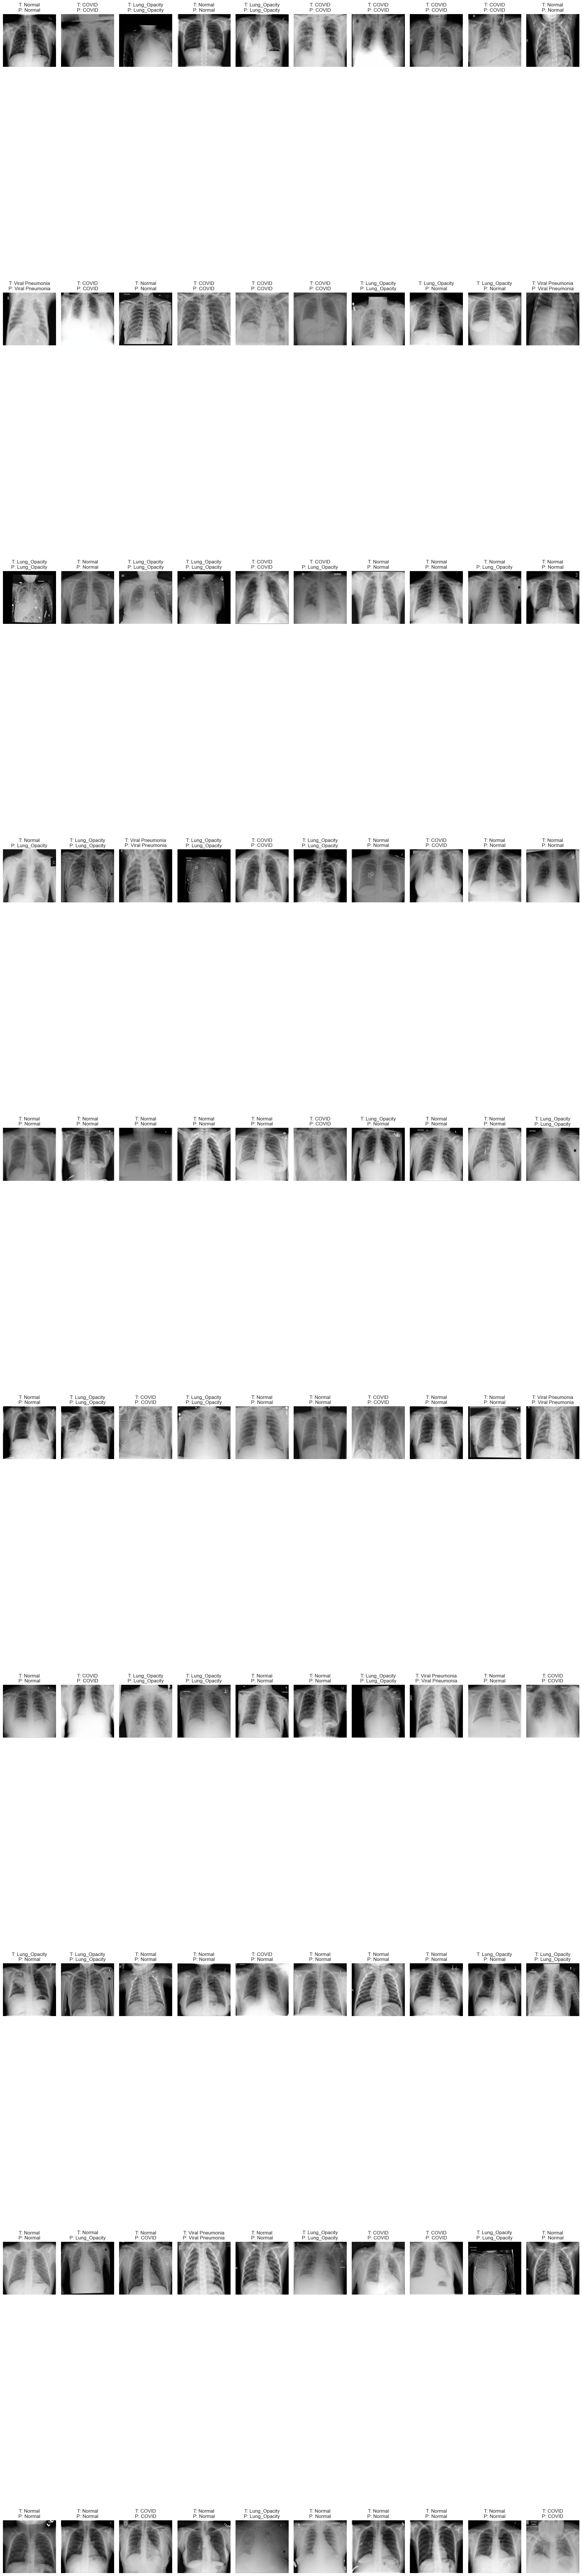

In [30]:
import random

def visualize_random_100_predictions(model, dataloader, classes, num_images=100):
    model.eval()
    collected_images, collected_labels, collected_preds = [], [], []
    
    with torch.no_grad():
        # Loop over the dataset and randomly sample images until we collect 100
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Move tensors to CPU for numpy conversion
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()
            
            # Select a random subset of images from the batch if needed
            indices = list(range(images.shape[0]))
            random.shuffle(indices)
            for idx in indices:
                if len(collected_images) < num_images:
                    collected_images.append(images[idx])
                    collected_labels.append(labels[idx])
                    collected_preds.append(preds[idx])
                else:
                    break
            if len(collected_images) >= num_images:
                break  # Stop once we have 100 images

    # Plot the 100 random images with true and predicted labels
    plt.figure(figsize=(20, 100))  # Adjust figure size for better viewing
    for i in range(num_images):
        plt.subplot(num_images // 10, 10, i + 1)
        
        # Display the image
        img = collected_images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"T: {classes[collected_labels[i]]}\nP: {classes[collected_preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 100 random sample predictions
visualize_random_100_predictions(trained_model, test_loader, classes, num_images=100)
